In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn import metrics
import os
from PIL import Image


dataset source : https://www.kaggle.com/kaustubhdikshit/neu-surface-defect-database

In [ ]:

data_dir = 'NEU-DET'


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
class NEUSurfaceDefectsDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_paths = []
        self.labels = []


        defect_classes = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
        for label, defect_class in enumerate(defect_classes):
            class_dir = os.path.join(self.root_dir, self.split, 'images', defect_class)
            image_files = os.listdir(class_dir)
            self.image_paths.extend([os.path.join(class_dir, img_file) for img_file in image_files])
            self.labels.extend([label] * len(image_files))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:

dataset = NEUSurfaceDefectsDataset(root_dir=data_dir, split='train', transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.pipeline = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 56 * 56, 64),  # Updated input size
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.pipeline(x)
        x = self.fc_layers(x)
        return x

In [ ]:
# Initialize the model
model = CNNClassifier()

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [ ]:
# Training parameters
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNClassifier(
  (pipeline): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=100352, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    phases = ['train', 'val', 'test']  # Add 'test' phase
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f} at epoch {best_epoch}')

    model.load_state_dict(best_model_wts)

    return model, training_curves

# Train the model
model, training_curves = train_classification_model(model, {'train': train_loader, 'val': val_loader, 'test': test_loader},
                                     {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)},
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 1.5479 Acc: 0.5165
val   Loss: 0.7067 Acc: 0.7500
test  Loss: 0.9208 Acc: 0.7361

Epoch 2/10
----------
train Loss: 0.6153 Acc: 0.7856
val   Loss: 0.4023 Acc: 0.8542
test  Loss: 0.5085 Acc: 0.8333

Epoch 3/10
----------
train Loss: 0.3655 Acc: 0.8828
val   Loss: 0.2936 Acc: 0.8819
test  Loss: 0.4364 Acc: 0.8819

Epoch 4/10
----------
train Loss: 0.2521 Acc: 0.9201
val   Loss: 0.2863 Acc: 0.8889
test  Loss: 0.3775 Acc: 0.9028

Epoch 5/10
----------
train Loss: 0.1938 Acc: 0.9323
val   Loss: 0.1337 Acc: 0.9792
test  Loss: 0.3251 Acc: 0.9097

Epoch 6/10
----------
train Loss: 0.1840 Acc: 0.9384
val   Loss: 0.2006 Acc: 0.9236
test  Loss: 0.4549 Acc: 0.8611

Epoch 7/10
----------
train Loss: 0.1541 Acc: 0.9479
val   Loss: 0.1331 Acc: 0.9583
test  Loss: 0.2779 Acc: 0.9306

Epoch 8/10
----------
train Loss: 0.0904 Acc: 0.9774
val   Loss: 0.1789 Acc: 0.9444
test  Loss: 0.3398 Acc: 0.9097

Epoch 9/10
----------
train Loss: 0.0830 Acc: 0.9757
val   Loss: 0.1696

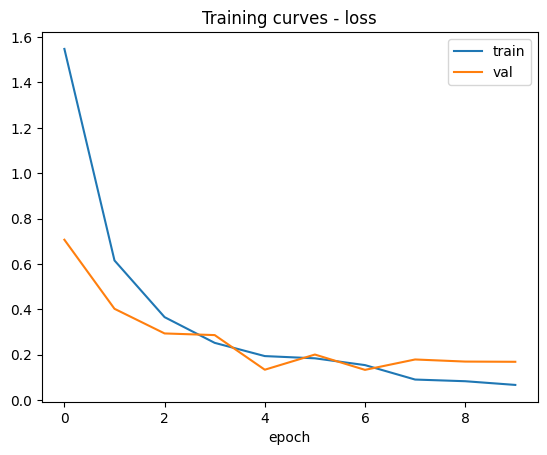

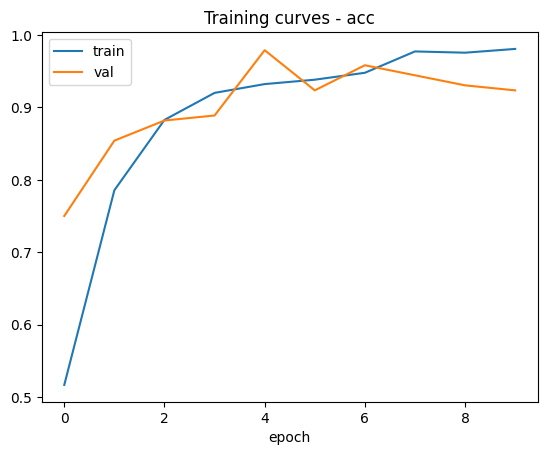

In [ ]:
# Plotting training curves
def plot_training_curves(training_curves,
                         phases=['train', 'val'],
                         metrics=['loss', 'acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase + '_' + metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

plot_training_curves(training_curves)

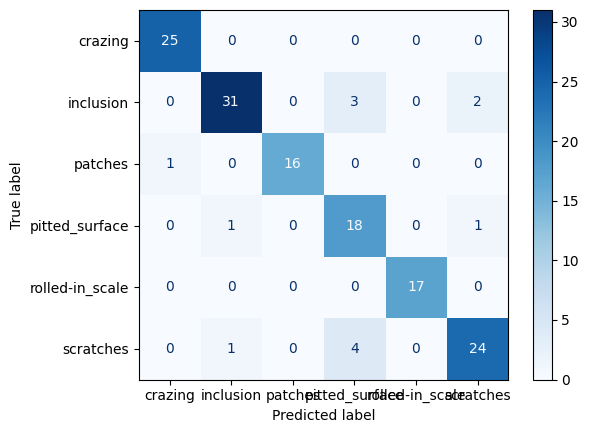

Training and evaluation complete.


In [ ]:
# Confusion matrix plotting function
def plot_cm(model, device, dataloader, class_labels):
    model.eval()
    all_labels = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels = torch.cat((all_labels, labels), 0)
        all_preds = torch.cat((all_preds, preds), 0)

    cm = metrics.confusion_matrix(all_labels.cpu(), all_preds.cpu())
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues)

# Plotting confusion matrix
class_labels = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
plot_cm(model, device, test_loader, class_labels)
plt.show()
print("Training and evaluation complete.")